# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    O_MODEL = tf.keras.applications.vgg19.VGG19(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['block5_conv4']
    LAST_LAYER = 'block5_conv4'
    PREPROCESSING = tf.keras.applications.vgg19.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.dense(o_outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 1.3418 - accuracy: 0.6636

947/947 [==============================] - 2396s 3s/step - loss: 1.3418 - accuracy: 0.6636 - val_loss: 1.1970 - val_accuracy: 0.6710
Epoch 2/200
947/947 [==============================] - 2352s 2s/step - loss: 1.2189 - accuracy: 0.6656 - val_loss: 1.2154 - val_accuracy: 0.6710
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 1.2033 - accuracy: 0.6656

947/947 [==============================] - 2332s 2s/step - loss: 1.2033 - accuracy: 0.6656 - val_loss: 1.1958 - val_accuracy: 0.6710
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 1.2009 - accuracy: 0.6662

947/947 [==============================] - 2424s 3s/step - loss: 1.2009 - accuracy: 0.6662 - val_loss: 1.1942 - val_accuracy: 0.6710
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 1.2013 - accuracy: 0.6662

947/947 [==============================] - 2343s 2s/step - loss: 1.2013 - accuracy: 0.6662 - val_loss: 1.1908 - val_accuracy: 0.6710
Epoch 6/200
947/947 [==============================] - 2328s 2s/step - loss: 1.2012 - accuracy: 0.6662 - val_loss: 1.1930 - val_accuracy: 0.6710
Epoch 7/200
947/947 [==============================] - 2343s 2s/step - loss: 1.2012 - accuracy: 0.6662 - val_loss: 1.1929 - val_accuracy: 0.6710
Epoch 8/200
947/947 [==============================] - 2342s 2s/step - loss: 1.2006 - accuracy: 0.6662 - val_loss: 1.1944 - val_accuracy: 0.6710
Epoch 9/200
947/947 [==============================] - 2340s 2s/step - loss: 1.2006 - accuracy: 0.6662 - val_loss: 1.1946 - val_accuracy: 0.6710
Epoch 10/200
947/947 [==============================] - 2338s 2s/step - loss: 1.2004 - accuracy: 0.6662 - val_loss: 1.1914 - val_accuracy: 0.6710
Epoch 11/200
947/947 [==============================] - ETA: 0s - loss: 1.2006 - accuracy: 0.6662

947/947 [==============================] - 2337s 2s/step - loss: 1.2006 - accuracy: 0.6662 - val_loss: 1.1896 - val_accuracy: 0.6710
Epoch 12/200
947/947 [==============================] - 2349s 2s/step - loss: 1.2001 - accuracy: 0.6662 - val_loss: 1.1922 - val_accuracy: 0.6710
Epoch 13/200
947/947 [==============================] - 2338s 2s/step - loss: 1.1999 - accuracy: 0.6662 - val_loss: 1.1917 - val_accuracy: 0.6710
Epoch 14/200
947/947 [==============================] - 2344s 2s/step - loss: 1.2004 - accuracy: 0.6662 - val_loss: 1.1908 - val_accuracy: 0.6710
Epoch 15/200
947/947 [==============================] - 2329s 2s/step - loss: 1.1999 - accuracy: 0.6662 - val_loss: 1.1913 - val_accuracy: 0.6710
Epoch 16/200
947/947 [==============================] - 2340s 2s/step - loss: 1.1997 - accuracy: 0.6662 - val_loss: 1.1934 - val_accuracy: 0.6710


## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 250s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.5,
 'basal cell carcinoma': 0.5,
 'dermatofibroma': 0.5,
 'melanoma': 0.5,
 'nevus': 0.5,
 'pigmented benign keratosis': 0.5,
 'seborrheic keratosis': 0.5,
 'solar lentigo': 0.5,
 'squamous cell carcinoma': 0.5,
 'vascular lesion': 0.5}

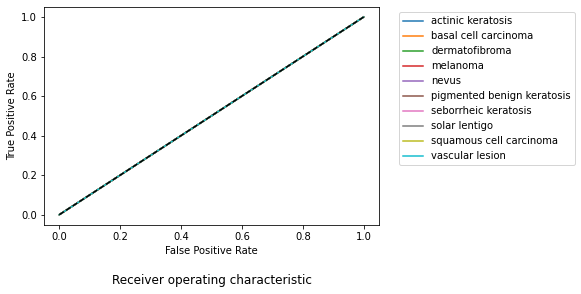

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

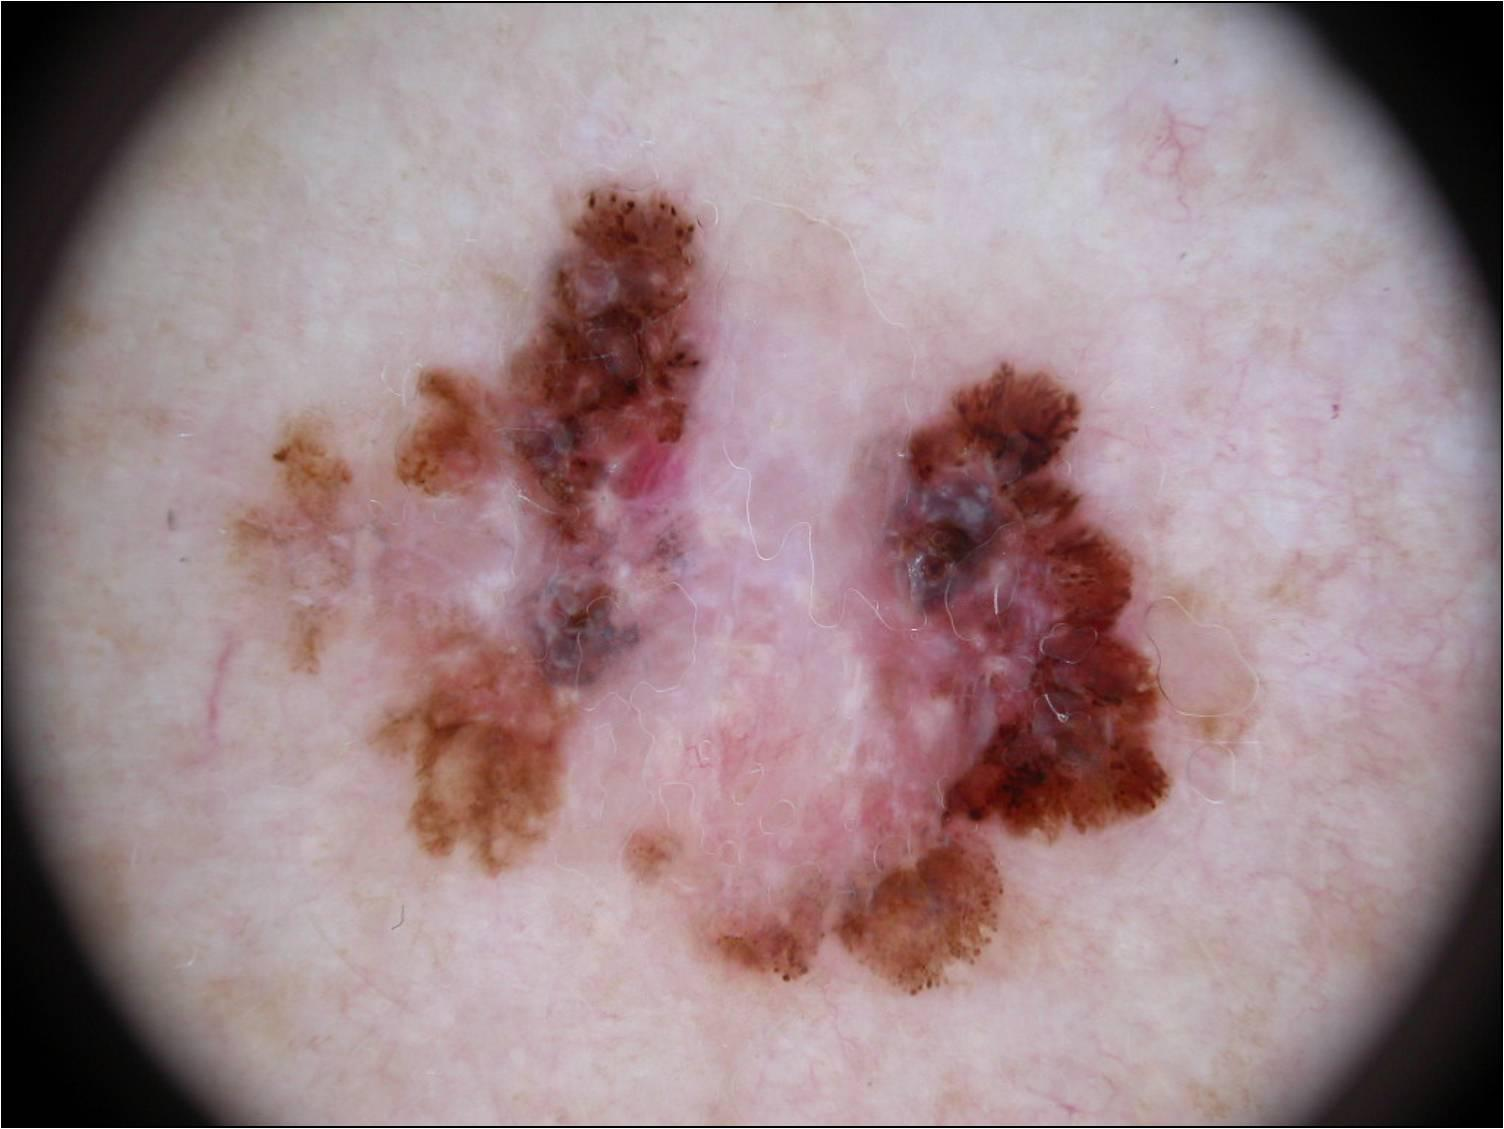

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

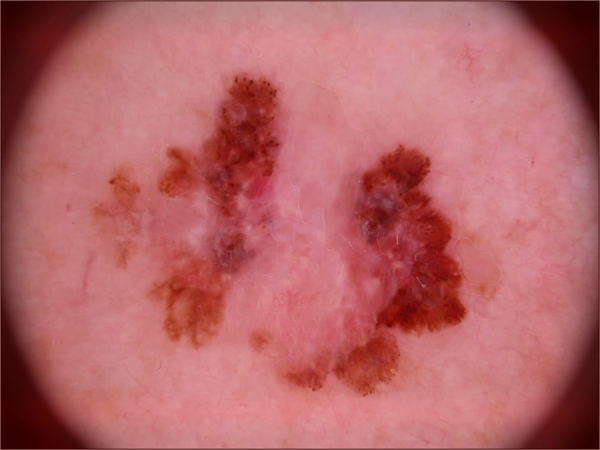

In [23]:
display_gradcam(melanoma_im_path, heatmap)